# D214 Capstone
# Modeling Inflation Adusted Recessionary Lumber Prices
# Early 1990's Recession
## Eric Yarger

# Import Packages

In [1]:
# Import Initial Libraries
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy import stats
from statsmodels.tsa.stattools import adfuller
import statsmodels
import datetime
import platform
from pmdarima.arima import ndiffs
from statsmodels.tsa.seasonal import seasonal_decompose
from pylab import rcParams
from statsmodels.graphics.tsaplots import plot_acf
from sklearn.metrics import mean_squared_error
from math import sqrt
from statsmodels.graphics.tsaplots import plot_pacf
import warnings
from scipy import signal
from pmdarima.arima import StepwiseContext
from pmdarima.arima import auto_arima
from pmdarima.model_selection import train_test_split

### Environment

In [2]:
# Windows 10, Anaconda, JupyterLab, JupyterNotebook
# Jupyter environment version
!jupyter --version

Selected Jupyter core packages...
IPython          : 7.31.1
ipykernel        : 6.15.2
ipywidgets       : not installed
jupyter_client   : 7.3.5
jupyter_core     : 4.10.0
jupyter_server   : 1.18.1
jupyterlab       : 3.4.4
nbclient         : 0.5.13
nbconvert        : 6.4.4
nbformat         : 5.5.0
notebook         : 6.4.12
qtconsole        : not installed
traitlets        : 5.1.1


In [3]:
# Python Version
print(platform.python_version())

3.7.13


In [4]:
#Load Medical Dataset 
df = pd.read_csv('C:/Users/ericy/Desktop/lumber_trading_days_adj.csv')

# Data Selection for Analysis

In [5]:
#------ Select Data Set for Recession
df = df[3938:4864]

In [6]:
df

,Date,Trading Days,2022_Value,Value
3938,1988-07-06,3939,462.4340,194.30
3939,1988-07-07,3940,465.2900,195.50
3940,1988-07-08,3941,473.8580,199.10
3941,1988-07-11,3942,474.8100,199.50
3942,1988-07-12,3943,472.9060,198.70
...,...,...,...,...
4859,1992-02-26,4860,477.0428,239.72
4860,1992-02-27,4861,479.3910,240.90
4861,1992-02-28,4862,479.7492,241.08
4862,1992-03-02,4863,480.5850,241.50


# D1: Exploratory Data Analysis

In [7]:
df = df[['Trading Days','2022_Value']]

In [8]:
df

,Trading Days,2022_Value
3938,3939,462.4340
3939,3940,465.2900
3940,3941,473.8580
3941,3942,474.8100
3942,3943,472.9060
...,...,...
4859,4860,477.0428
4860,4861,479.3910
4861,4862,479.7492
4862,4863,480.5850


# EDA

In [9]:
df.head()

,Trading Days,2022_Value
3938,3939,462.434
3939,3940,465.290
3940,3941,473.858
3941,3942,474.810
3942,3943,472.906


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 926 entries, 3938 to 4863
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Trading Days  926 non-null    int64  
 1   2022_Value    926 non-null    float64
dtypes: float64(1), int64(1)
memory usage: 14.6 KB


In [11]:
df.shape

(926, 2)

In [12]:
df.describe()

,Trading Days,2022_Value
count,926.000000,926.000000
mean,4401.500000,413.590309
std,267.457473,29.824984
min,3939.000000,316.917000
25%,4170.250000,400.136900
50%,4401.500000,418.709400
75%,4632.750000,427.207250
max,4864.000000,508.392000


In [13]:
df.isnull().any()

Trading Days    False
2022_Value      False
dtype: bool

## Line Graph Visualization

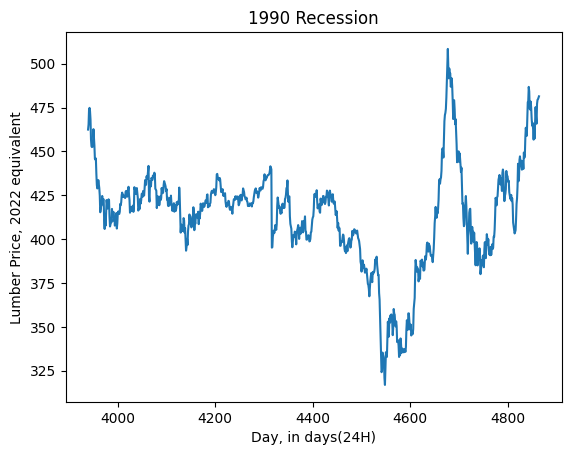

In [14]:
#-------
plt.plot(df['Trading Days'],df['2022_Value'])
plt.title('1990 Recession')
plt.xlabel('Day, in days(24H)')
plt.ylabel('Lumber Price, 2022 equivalent')
plt.show()

# Data Cleaning

In [15]:
# Drop any null columns
df = df.dropna()

# D2: Time Step Formatting, Indexing



### Set df['Trading Days'] to Index

In [16]:
# Day to datetime
df['Trading Days'] = pd.to_datetime(df['Trading Days'], unit='D')

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 926 entries, 3938 to 4863
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Trading Days  926 non-null    datetime64[ns]
 1   2022_Value    926 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 21.7 KB


In [18]:
# Set Day as Index
df.set_index('Trading Days',inplace=True)

In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 926 entries, 1980-10-14 to 1983-04-27
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   2022_Value  926 non-null    float64
dtypes: float64(1)
memory usage: 14.5 KB


In [20]:
df

,2022_Value
Trading Days,
1980-10-14,462.4340
1980-10-15,465.2900
1980-10-16,473.8580
1980-10-17,474.8100
1980-10-18,472.9060
...,...
1983-04-23,477.0428
1983-04-24,479.3910
1983-04-25,479.7492


# D3 Stationarity Analysis
### Augmented Dickey Fuller (ADF) Test
### Assess stationarity of dataset

In [21]:
# Code Reference (Making time series stationary | Python, n.d.)
dicky_fuller_test = adfuller(df)

In [22]:
dicky_fuller_test

(-2.312794090362915,
 0.16787481888011768,
 3,
 922,
 {'1%': -3.437462363899248,
  '5%': -2.8646798473884134,
  '10%': -2.568441851017076},
 5274.655766939205)

In [23]:
# Results show p = .16787
# Data does not reject null hypothesis at p < .05
# Therefore, Time series is determined to be non-stationary

# D4 Differencing
## 1st and 2nd order Differencing
### finding 'd' for ARIMA model

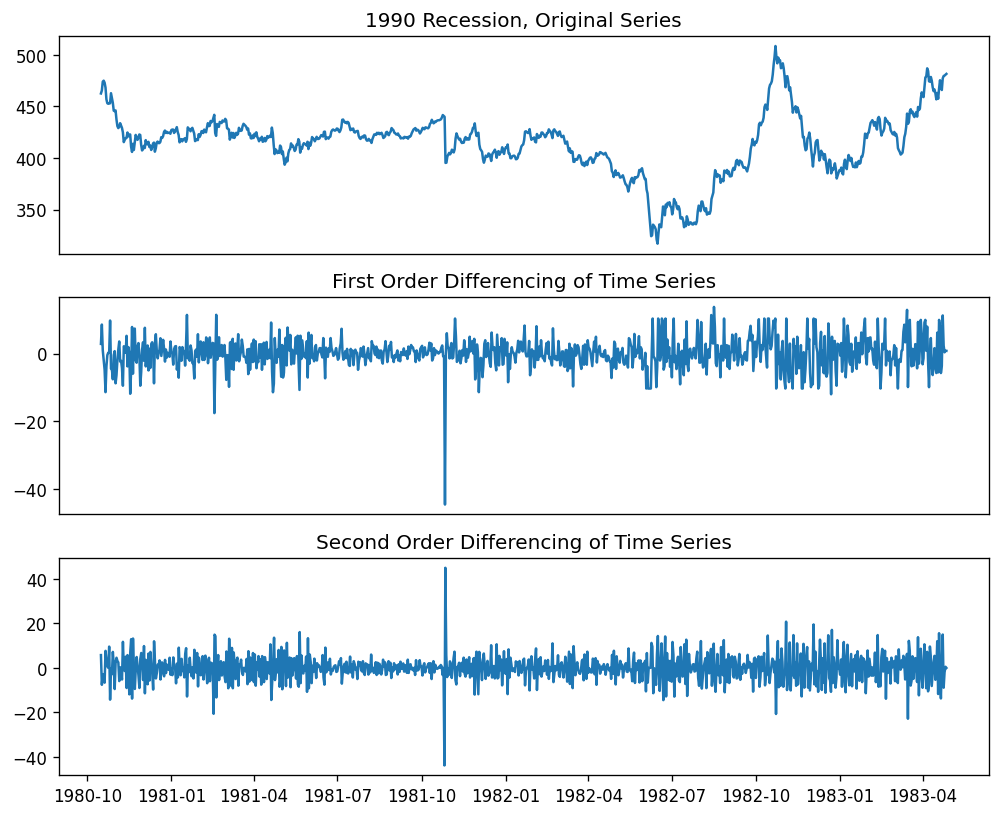

In [24]:
# Set plot parameters for multi-ax subplots
plt.rcParams.update({'figure.figsize':(10,8), 'figure.dpi':120})
 
# Establish that there are three subplots
fig, (ax1, ax2, ax3) = plt.subplots(3)

# Plot the original dataset 
ax1.plot(df); ax1.set_title('1990 Recession, Original Series'); ax1.axes.xaxis.set_visible(False)

# First Order differencing of Time Series 
ax2.plot(df.diff()); ax2.set_title('First Order Differencing of Time Series'); ax2.axes.xaxis.set_visible(False)

# Second Order Differencing of Time Series
ax3.plot(df.diff().diff()); ax3.set_title('Second Order Differencing of Time Series')

# Plot all three graphs
plt.show()

In [25]:
# Using pmdarima's ndiffs to find differencing term
# Code reference (Verma, 2021)

kpss_diffs = ndiffs(df, alpha=0.05, test='kpss', max_d=6)
adf_diffs = ndiffs(df, alpha=0.05, test='adf', max_d=6)
n_diffs = max(adf_diffs, kpss_diffs)

print(f"Estimated differencing term: {n_diffs}")

Estimated differencing term: 1


# D5 Seasonality Analysis

In [26]:
# Code Reference (Boston, 2020)
result = seasonal_decompose(df)

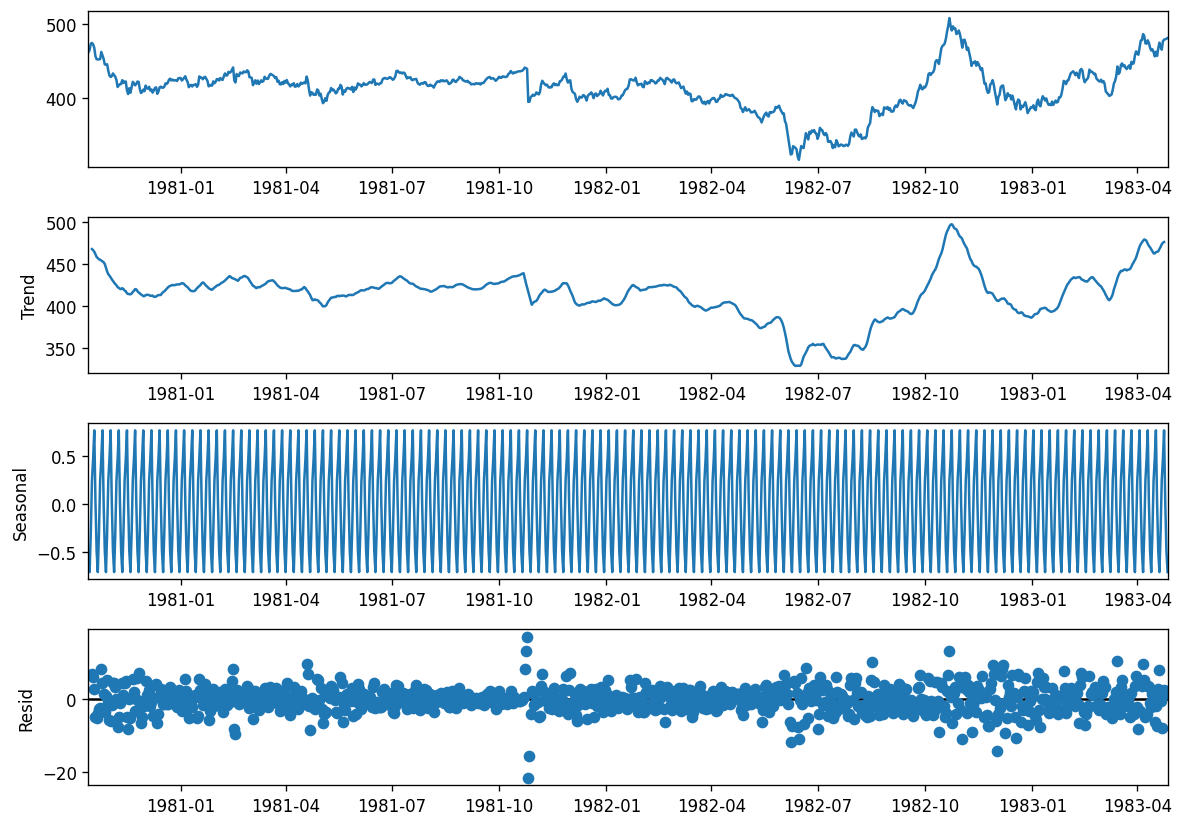

In [27]:
# plotting the result of our seasonal decomposition from the step above
rcParams['figure.figsize'] = 10,7
result.plot();

# D6 ACF and PACF

## Finding order of MA term 'q'
### Using Autocorrelation function (ACF)

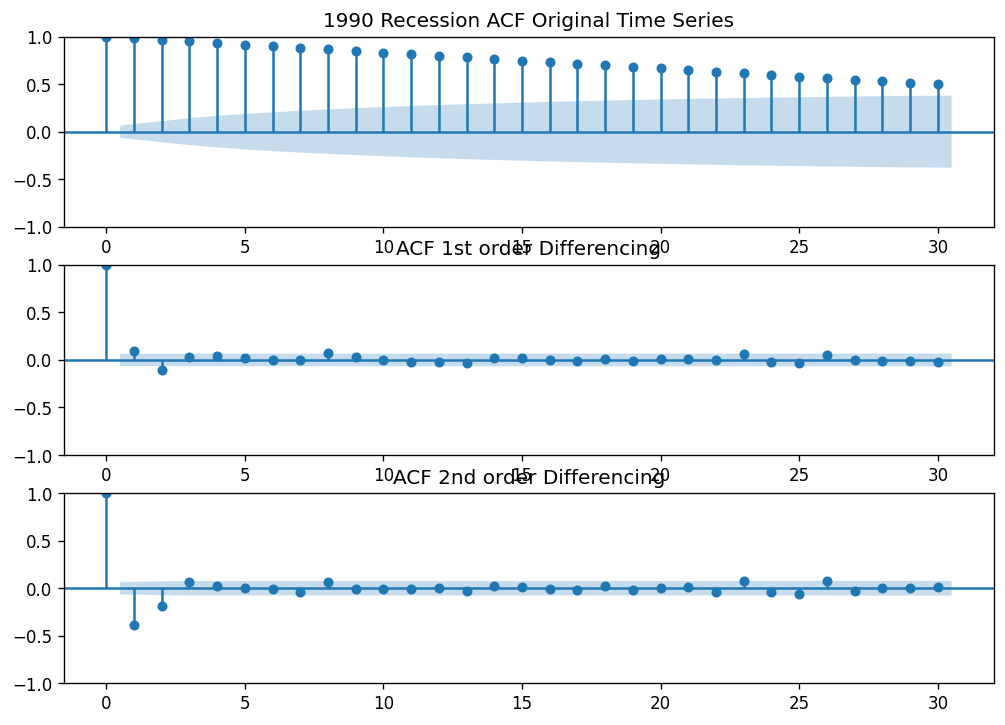

In [28]:
fig, (ax1, ax2, ax3) = plt.subplots(3)
plot_acf(df, ax=ax1, title='1990 Recession ACF Original Time Series');
plot_acf(df.diff().dropna(), ax=ax2, title='ACF 1st order Differencing');
plot_acf(df.diff().diff().dropna(), ax=ax3, title='ACF 2nd order Differencing');

## Finding order of AR term 'p'
### Using Partial autocorrelation (PACF)

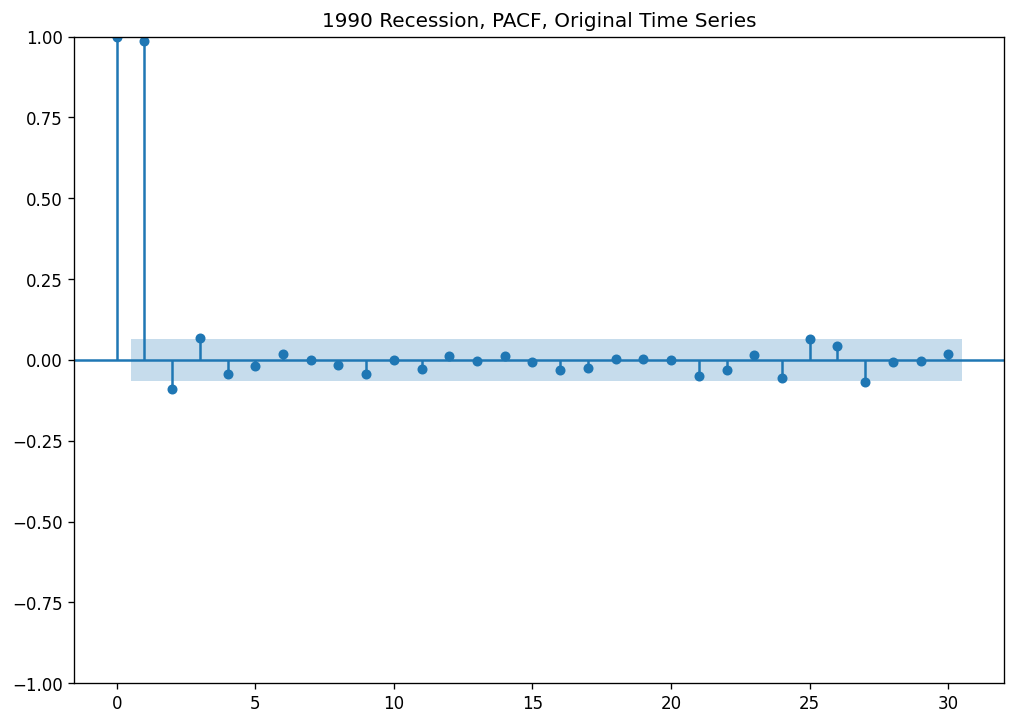

In [29]:
warnings.filterwarnings("ignore")
plot_pacf(df.dropna(), title='1990 Recession, PACF, Original Time Series');

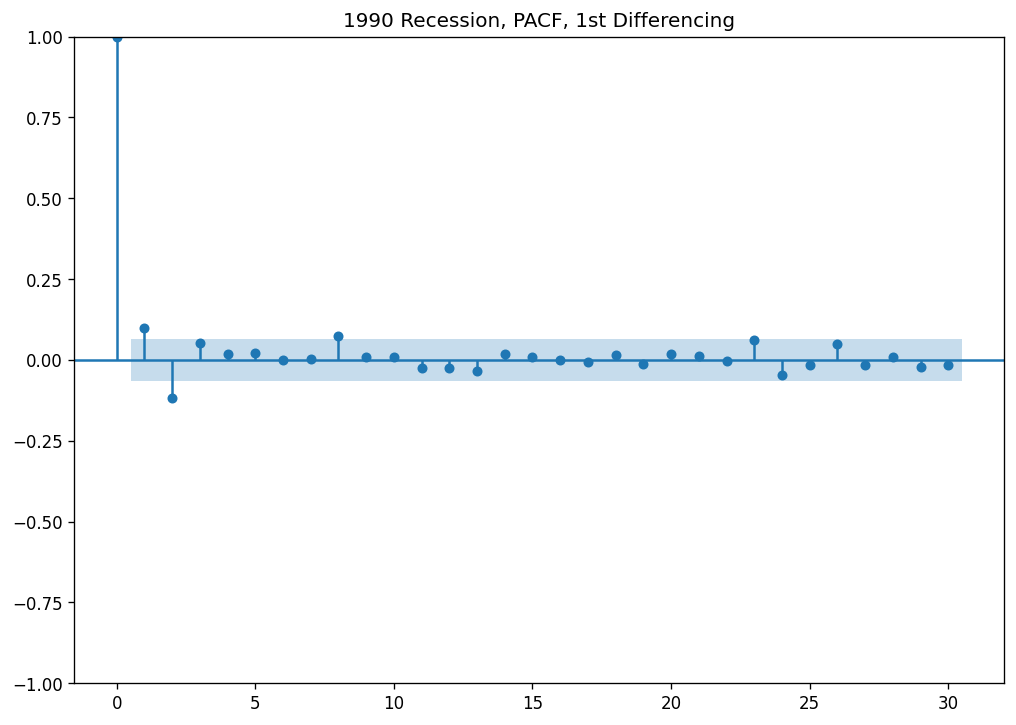

In [30]:
plot_pacf(df.diff().dropna(), title='1990 Recession, PACF, 1st Differencing');

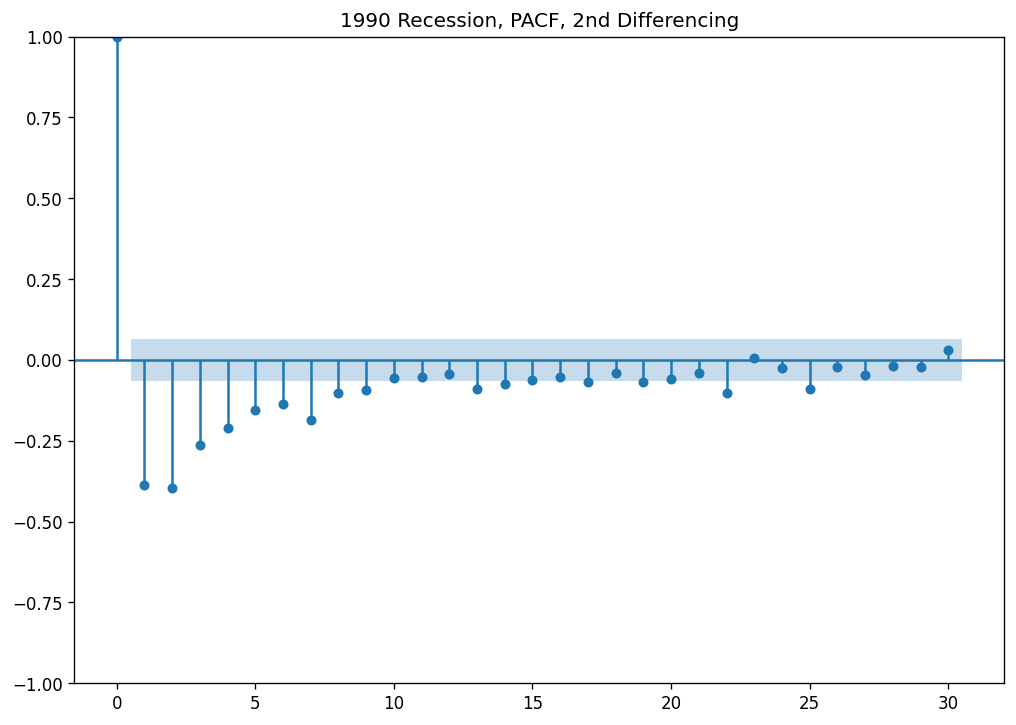

In [31]:
plot_pacf(df.diff().diff().dropna(), title='1990 Recession, PACF, 2nd Differencing');

# D7 Spectral Density

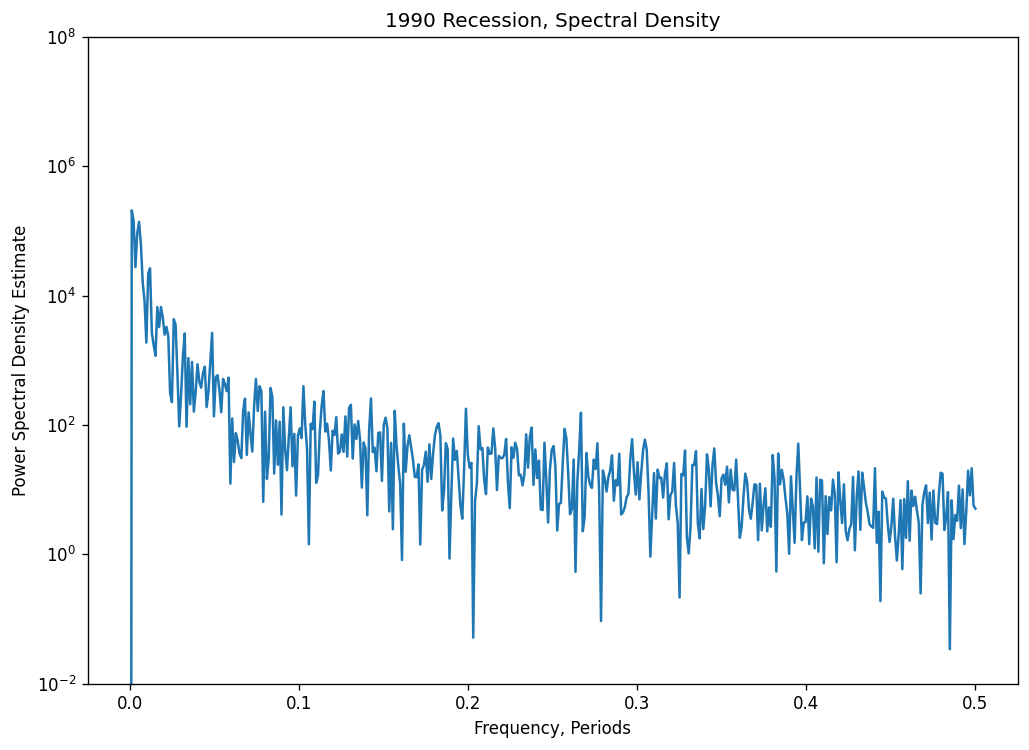

In [32]:
# Code Reference (Festus, 2022)

# signal periodogram
f, Pxx_den = signal.periodogram(df['2022_Value'])

# plotting semilogy - pyplot module used to make a plot with log scaling on the y-axis
plt.semilogy(f, Pxx_den)

# Setting coordinate values and titles for Spectral Density Graph
# setting y-axis min and max value
plt.ylim(1e-2, 1e8)

# Graph Title
plt.title('1990 Recession, Spectral Density')

# X label for Periods
plt.xlabel('Frequency, Periods')

# Y Label for SD Estimate
plt.ylabel('Power Spectral Density Estimate')
plt.show()

# D8 Create Train/Test Datasets

## Dataset Size = 926 cases
## 80/20 Train/Test Split
## Split is 741 / 185

In [33]:
# ------Splitting data into Test and Train sets using pmdarima's train_test_split
# code reference (Smith, 2019)

train, test = train_test_split(df, train_size=741)

In [34]:
train

,2022_Value
Trading Days,
1980-10-14,462.434
1980-10-15,465.290
1980-10-16,473.858
1980-10-17,474.810
1980-10-18,472.906
...,...
1982-10-20,490.383
1982-10-21,498.042
1982-10-22,508.392


In [35]:
test

,2022_Value
Trading Days,
1982-10-25,497.2140
1982-10-26,494.1090
1982-10-27,494.5230
1982-10-28,486.8640
1982-10-29,487.8990
...,...
1983-04-23,477.0428
1983-04-24,479.3910
1983-04-25,479.7492


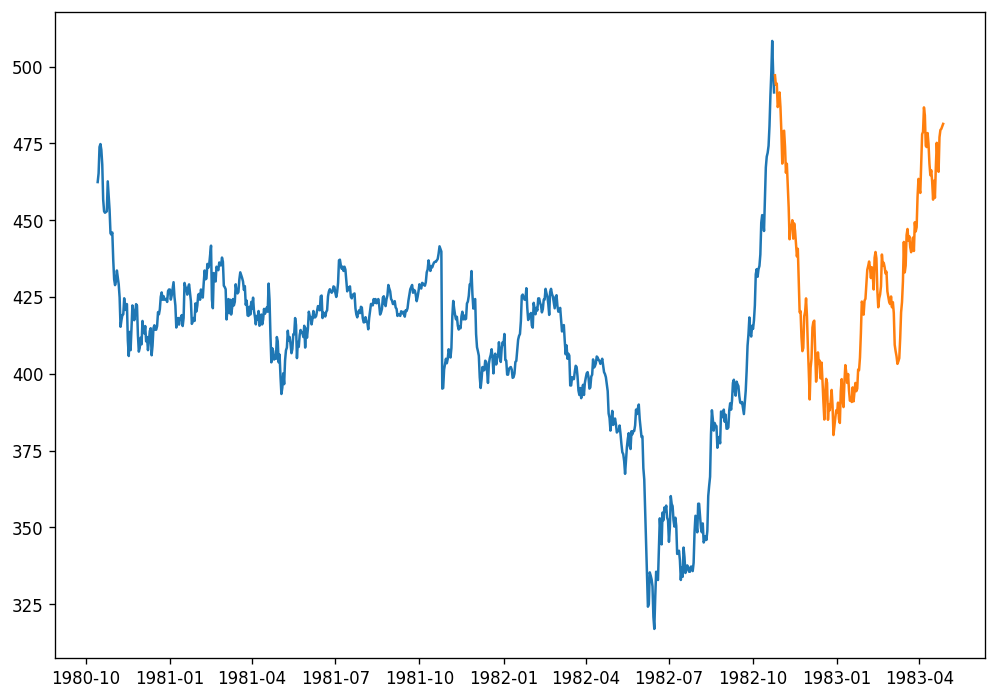

In [36]:
# Plot training data
plt.plot(train)

# Plot Test Data
plt.plot(test)

In [37]:
print(train.shape)
print(test.shape)

(741, 1)
(185, 1)


# D9 Auto-arima ARIMA Modeling
## Using pmdarima's auto_arima

In [38]:
# Fit the model using auto_arima
# Auto-arima code reference (6. Tips to using auto_arima — pmdarima 2.0.1 documentation, n.d.)
# Additional code reference (Pmdarima.arima.AutoARIMA — pmdarima 2.0.1 documentation, n.d.)
# Auto-arima, initial parameter attempt
# Code Reference (Kosaka, 2021)

# Establish auto_arima to run ARIMA and take into account
# Any Seasonality of the data, and any trends found.
model = auto_arima(train, start_p=1, start_q=1,
                   test='adf',
                   max_p=3,
                   max_q=3,
                   max_d=3,
                   seasonal=True,
                   stationarity=False,
                   seasonal_test='ocsb',
                   trace=True,
                   error_action='ignore',
                   suppress_warnings=True,
                   stepwise=True,
                  trend='c')

# Print Summary of Best AIC Minimized SARIMAX Model
print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=4221.106, Time=0.23 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4235.930, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4230.964, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4229.001, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4235.930, Time=0.02 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=4222.101, Time=0.25 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=4222.076, Time=0.22 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=4221.790, Time=0.13 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=4223.970, Time=0.13 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=4224.076, Time=0.56 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=4221.106, Time=0.14 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0]          
Total fit time: 1.887 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  

In [68]:
model = auto_arima(train, trace=True)

# Print Summary of Best AIC Minimized SARIMAX Model
print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=4224.076, Time=0.58 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4235.930, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4230.964, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4229.001, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4233.995, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=4222.076, Time=0.22 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=4221.790, Time=0.12 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=4222.109, Time=0.20 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=4221.106, Time=0.14 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=4222.101, Time=0.27 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=4223.970, Time=0.12 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=4219.164, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=4227.051, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=4229.015, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0]          

In [40]:
model.conf_int()

,0,1
ar.L1,-0.864537,-0.284080
ma.L1,0.447082,0.964480
sigma2,16.822537,17.944259


# Visualizing Model Results

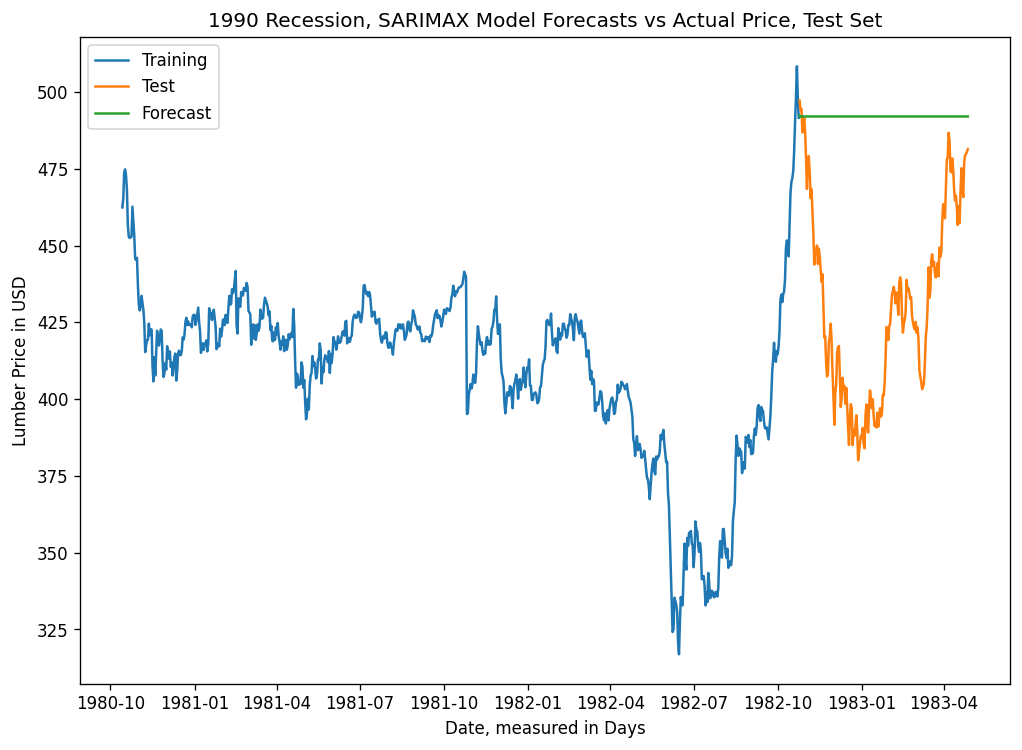

In [41]:
# Prediction assignment, predicted revenue column named
# Training, Test, and Predicted data plotted together
# Code Reference (Matplotlib.pyplot.plot — Matplotlib 3.6.0 documentation, n.d.)

# ------Creating varible with forecast values
forecast = pd.DataFrame(model.predict(n_periods = 185))

# Naming forecast_revenue column in forecast variable
forecast.columns = ['forecast_prices']

# Establish plot parameters for Forecast

# Plot figure size
plt.figure(figsize=(10,7))

# Training data
plt.plot(train,label="Training")

# Annotate X-axis label
plt.xlabel('Date, measured in Days')

# Annotate Y-axis label
plt.ylabel('Lumber Price in USD')

# Annotate Plot Title
plt.title('1990 Recession, SARIMAX Model Forecasts vs Actual Price, Test Set')

# Plot Test Data
plt.plot(test,label="Test")

# Plot Forecast Data
plt.plot(forecast,label="Forecast")

# Plot legend in upper lefthand corner
plt.legend(loc = 'upper left')

# Show Plot
plt.show()

In [42]:
forecast

,forecast_prices
1982-10-25,492.282685
1982-10-26,491.904971
1982-10-27,492.121895
1982-10-28,491.997314
1982-10-29,492.068862
...,...
1983-04-23,492.042761
1983-04-24,492.042761
1983-04-25,492.042761
1983-04-26,492.042761


# D10 Accuracy Metrics for our forecast

In [43]:
# RMSE and MAE to test model accuracy

In [44]:
# Create array of actual Revenue values, stored in Test variable

test_array = test[['2022_Value']].to_numpy()
#test_array

In [45]:
test_array.shape

(185, 1)

In [46]:
forecast

,forecast_prices
1982-10-25,492.282685
1982-10-26,491.904971
1982-10-27,492.121895
1982-10-28,491.997314
1982-10-29,492.068862
...,...
1983-04-23,492.042761
1983-04-24,492.042761
1983-04-25,492.042761
1983-04-26,492.042761


In [47]:
# Predictions to numpy array
predicted_array = forecast[['forecast_prices']].to_numpy()

In [48]:
predicted_array.shape

(185, 1)

In [49]:
#RMSE Calculation

rmse = sqrt(mean_squared_error(test_array, predicted_array))
print ('RMSE = ' + str(rmse))

RMSE = 69.20596198874226


In [50]:
# MAE Calculation

def mae(y_true, predictions):
    y_true, predictions = np.array(y_true), np.array(predictions)
    return np.mean(np.abs(y_true - predictions))

true = test_array
predicted = predicted_array

print(mae(true, predicted))

62.12480063004482


# D11 Visualizing Model Forecast Confidence Intervals at 20% CI# Visualizing Model Forecasts

In [51]:
# Model Standard Error calculations, computed numerical Hessian

std_error = model.bse()
print(std_error)

ar.L1     0.148078
ma.L1     0.131992
sigma2    0.286159
dtype: float64


In [52]:
# Generate Model confidence intervals

conf_int = model.conf_int()

In [53]:
# ------Generate Forecast Prediction Intervals at 90% Confidence

y_forec, conf_int = model.predict(185, return_conf_int=True, alpha=0.8)
print(conf_int)

[[491.22639477 493.33897531]
 [490.30992726 493.50001443]
 [490.17554048 494.06825026]
 [489.73088261 494.26374487]
 [489.53415865 494.60356544]
 [489.24438258 494.8111599 ]
 [489.04306442 495.05967566]
 [488.81850775 495.25712634]
 [488.62925039 495.46195091]
 [488.43797806 495.64428286]
 [488.26324742 495.82414804]
 [488.09226856 495.99217808]
 [487.93067808 496.15546209]
 [487.77388343 496.31128414]
 [487.62340583 496.46232031]
 [487.47744946 496.60795589]
 [487.33626804 496.74932154]
 [487.19905573 496.88642805]
 [487.06570771 497.01983683]
 [486.93579267 497.14971697]
 [486.80912895 497.27640074]
 [486.68544336 497.40007482]
 [486.56455866 497.52096613]
 [486.44627927 497.63924172]
 [486.33045144 497.75507173]
 [486.2169243  497.86859761]
 [486.10556855 497.97995409]
 [485.99626267 498.08925955]
 [485.88889832 498.19662414]
 [485.78337508 498.30214724]
 [485.67960165 498.40592075]
 [485.5774936  498.50802876]
 [485.47697333 498.60854905]
 [485.37796894 498.70755342]
 [485.28041389

In [54]:
# Assign Predictions to pandas DataFrame

conf_pd = pd.DataFrame(conf_int, columns =['Low_Prediction','High_Prediction'])

#Assign Low predictions to variable
low_prediction = conf_pd['Low_Prediction']

#Assign High predictions to variable
high_prediction = conf_pd['High_Prediction']

In [55]:
# Read out Test and Train sets to csv file
# Open csv files in Google Sheets, Add Day Column
# Dates align with 'test' variable, which contains actual revenue figures

low_prediction.to_csv('C:/Users/ericy/Desktop/Low_Prediction.csv')
high_prediction.to_csv('C:/Users/ericy/Desktop/High_Prediction.csv')

In [56]:
#-----Load predictions, date column added

low_pred = pd.read_csv('C:/Users/ericy/Desktop/1990_Low_Prediction.csv')
high_pred = pd.read_csv('C:/Users/ericy/Desktop/1990_High_Prediction.csv')

In [57]:
# Variable exploration to ensure compatability with 'test' datetime timeframe
low_pred

,Date,Low_Prediction
0,1982-10-25,491.226395
1,1982-10-26,490.309927
2,1982-10-27,490.175541
3,1982-10-28,489.730883
4,1982-10-29,489.534159
...,...,...
180,1983-04-23,476.648847
181,1983-04-24,476.606360
182,1983-04-25,476.563989
183,1983-04-26,476.521735


In [58]:
# Variable exploration to ensure compatability with 'test' datetime timeframe
high_pred

,Date,High_Prediction
0,1982-10-25,493.338975
1,1982-10-26,493.500014
2,1982-10-27,494.068250
3,1982-10-28,494.263745
4,1982-10-29,494.603565
...,...,...
180,1983-04-23,507.436676
181,1983-04-24,507.479163
182,1983-04-25,507.521533
183,1983-04-26,507.563788


## Convert Low and High Prediction 'Day' column to datetime and index

In [59]:
# Lower Predictions, Set Day as Index
low_pred['Date'] = pd.to_datetime(low_pred['Date'])

In [60]:
low_pred.set_index('Date',inplace=True)

In [61]:
# High Predictions, Day to datetime
high_pred['Date'] = pd.to_datetime(high_pred['Date'])

In [62]:
# High Predictions, Set Day as Index
high_pred.set_index('Date',inplace=True)

In [63]:
low_pred

,Low_Prediction
Date,
1982-10-25,491.226395
1982-10-26,490.309927
1982-10-27,490.175541
1982-10-28,489.730883
1982-10-29,489.534159
...,...
1983-04-23,476.648847
1983-04-24,476.606360
1983-04-25,476.563989


In [64]:
high_pred

,High_Prediction
Date,
1982-10-25,493.338975
1982-10-26,493.500014
1982-10-27,494.068250
1982-10-28,494.263745
1982-10-29,494.603565
...,...
1983-04-23,507.436676
1983-04-24,507.479163
1983-04-25,507.521533


# SARIMAX Model Forecast, With Confidence Interval = 20%, Vs Test Set

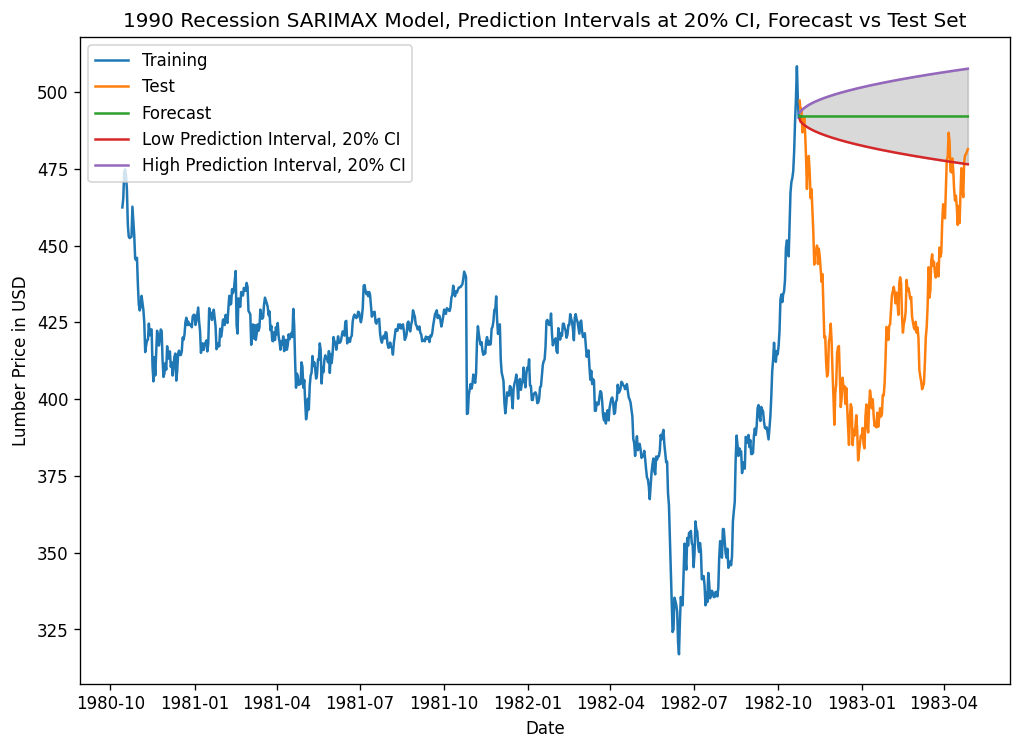

In [65]:
# Prediction assignment, predicted revenue column named
# Training, Test, and Predicted data plotted together
# Code Reference (Matplotlib.pyplot.plot — Matplotlib 3.6.0 documentation, n.d.)

# -----Creating varible with forecast values
forecast = pd.DataFrame(model.predict(n_periods = 185),index=test.index)

# Naming forecast_revenue column in forecast variable
forecast.columns = ['forecast_prices']

# Establish plot parameters for Forecast

# Plot figure size
plt.figure(figsize=(10,7))

# Training data
plt.plot(train,label="Training")

# Annotate X-axis label
plt.xlabel('Date')

# Annotate Y-axis label
plt.ylabel('Lumber Price in USD')

# Annotate Plot Title
plt.title('1990 Recession SARIMAX Model, Prediction Intervals at 20% CI, Forecast vs Test Set')

# Plot Test Data
plt.plot(test,label="Test")

# Plot Forecast Data
plt.plot(forecast,label="Forecast")

# Add Prediction Interval at 95% CI
plt.plot(low_pred,label='Low Prediction Interval, 20% CI')
plt.plot(high_pred,label='High Prediction Interval, 20% CI')
plt.fill_between(low_pred.index, low_pred['Low_Prediction'], high_pred['High_Prediction'], color='k', alpha=.15)

# Plot legend in upper lefthand corner
plt.legend(loc = 'upper left')


# Show Plot
plt.show()

# Is the null hypothesis Accepted or Rejected?

In [66]:
# Accept or reject the Null Hypothesis
# 1990 Recession we Accept the Null Hypothesis